<a href="https://colab.research.google.com/github/joaogwendling/python/blob/main/An%C3%A1lise_Explorat%C3%B3ria_Simples_(Vendas).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Análise de vendas**
Análise exploratória sobre vendas de uma empresa, feita com base [nesse vídeo](https://www.youtube.com/watch?v=eMOA1pPVUc4), como estudo. <sub><sup>[Repo](https://github.com/KeithGalli/Pandas-Data-Science-Tasks/blob/master/SalesAnalysis/SalesAnalysis.ipynb)<sup><sub> 

Algumas perguntas a serem respondidas com base no csv disponibilizado:


*   Qual o produto mais vendido?
*   Qual o produto que mais dá receita?
*   Qual cidade que mais dá receita?
*   Como as vendas se distribuem ao longo do dia?
*   Quais produtos são os mais vendidos em conjunto?


## Início
Importações das bibliotecas e dos dados

In [ ]:
import pandas as pd             # para a estrutura de tabela
import matplotlib.pyplot as plt # para os gráficos
import io                       # e esses dois últimos são
from google.colab import files  # para importar o arquivo

In [ ]:
uploaded = files.upload()

Saving all_data.csv to all_data.csv


In [ ]:
file_data = io.BytesIO(uploaded['all_data.csv'])
df = pd.read_csv(file_data)

## Limpeza

In [ ]:
# Podemos ver a estrutura dos dados
df.columns=['ID da ordem','Produto','Quantidade','Preço Unitário','Data','Endereço']
df.head()

,ID da ordem,Produto,Quantidade,Preço Unitário,Data,Endereço
0,176558,USB-C Charging Cable,2,11.95,04/19/19 08:46,"917 1st St, Dallas, TX 75001"
1,NaN,NaN,NaN,NaN,NaN,NaN
2,176559,Bose SoundSport Headphones,1,99.99,04/07/19 22:30,"682 Chestnut St, Boston, MA 02215"
3,176560,Google Phone,1,600,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"
4,176560,Wired Headphones,1,11.99,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"


A tabela é composta por 6 colunas. ID da ordem, produto, quantidade, preço unitário, data e endereço. De cara já vimos que existem valores nulos (```NaN```).

Podemos procurar as linhas que contém valores nulos com o método ```.isna()``` e ver o número dessas linhas.

In [ ]:
print('Existem '+ str(df[df.isna().any(axis=1)].shape[0]) +' linhas com valores nulos')
print('Que representam '+ "{:.3%}".format(df[df.isna().any(axis=1)].shape[0] / df.shape[0]) +' do total de linhas')




Existem 545 linhas com valores nulos
Que representam 0.292% do total de linhas


In [ ]:
# e podemos ver uma amostra das linhas com valores nulos para entender seu comportamento
df[df.isna().any(axis=1)].sample(7)

,ID da ordem,Produto,Quantidade,Preço Unitário,Data,Endereço
37439,NaN,NaN,NaN,NaN,NaN,NaN
82927,NaN,NaN,NaN,NaN,NaN,NaN
51163,NaN,NaN,NaN,NaN,NaN,NaN
112146,NaN,NaN,NaN,NaN,NaN,NaN
41855,NaN,NaN,NaN,NaN,NaN,NaN
50290,NaN,NaN,NaN,NaN,NaN,NaN
116757,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# vemos que as linhas que possuem valores nulos, estão inteiramente nulas, não tendo nenhum valor válido para análise
# sendo assim, excluiremos todas essas linhas

df = df.dropna(how='all')
print('Agora, existem '+ str(df[df.isna().any(axis=1)].shape[0]) +' linhas com valores nulos')

Agora, existem 0 linhas com valores nulos


Como próximo passo, podemos ver os formatos de dados das colunas, para procurar divergências com o esperado 

In [ ]:
df.dtypes

ID da ordem       object
Produto           object
Quantidade        object
Preço Unitário    object
Data              object
Endereço          object
dtype: object

Todos os formatos estão como ```object```. Alguns deveriam estar em outros formatos, como números (colunas Quantidade e Preço Unitário) e data (coluna Data). Faremos isso a seguir

In [ ]:
df['Preço Unitário'] = pd.to_numeric(df['Preço Unitário'])
df['Quantidade'] = pd.to_numeric(df['Quantidade'])
df['Data'] = pd.to_datetime(df['Data'])

ValueError: ignored

O resultado foi um erro (```Unable to parse string "Price Each" at position 517```). Aparentemente existem linhas com o texto 'Price Each' (o antigo nome da coluna) como seu valor. Vamos atrás dessas linhas

In [ ]:
df[df['Preço Unitário'] == 'Price Each'].sample(7)

,ID da ordem,Produto,Quantidade,Preço Unitário,Data,Endereço
46967,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
74053,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
34206,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
170324,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
112636,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
80221,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
2893,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address


Novamente vemos um erro que acomete a linha inteira, em que os cabeçalhos são repetidos como valores. Novamente vamos excluir tais linhas de nossa tabela, para em seguida, realizarmos novamente as operações para mudar os tipos de dados

In [ ]:
# exclusão das linhas
df = df[df['Preço Unitário'] != 'Price Each']

# repetição dos comandos para transformar tipo de dados
df['Preço Unitário'] = pd.to_numeric(df['Preço Unitário'])
df['Quantidade'] = pd.to_numeric(df['Quantidade'])
df['Data'] = pd.to_datetime(df['Data'])

Sem erros dessa vez. Podemos conferir os tipos novamente

In [ ]:
df.dtypes

ID da ordem               object
Produto                   object
Quantidade                 int64
Preço Unitário           float64
Data              datetime64[ns]
Endereço                  object
dtype: object

## Preparação
Preparar algumas colunas para as análises que serão feitas

Para facilitar as perguntas feitas no início, faremos três dimensões:
* Mês da venda
* Hora da venda
* Cidade da venda



In [ ]:
# coluna de mês
df['Mês'] = df['Data'].dt.month

# coluna de hora
df['Hora'] = df['Data'].dt.hour

# coluna de cidade
    # vemos que a cidade é o termo entre as vírgulas da coluna Purchase Address
df['Cidade'] = df['Endereço'].apply(lambda x: x.split(', ')[1]+' ('+x.split(', ')[2][:2]+')')
                        # para cada x no endereço, separa os termos pela vírgula e retorna o segundo termo([1]) e 
                        # mais as primeiras duas letras([:2]) do terceiro termo([2])

Além disso, podemos fazer uma outra métrica **Receita**, que é a renda de cada venda, sendo a multiplicação da quantidade vendida pelo preço

In [ ]:
df['Receita'] = df['Quantidade'] * df['Preço Unitário']

In [ ]:
# as novas colunas
df.sample(5)

,ID da ordem,Produto,Quantidade,Preço Unitário,Data,Endereço,Mês,Hora,Cidade,Receita
173173,276896,USB-C Charging Cable,1,11.95,2019-10-30 17:39:00,"898 Forest St, San Francisco, CA 94016",10,17,San Francisco (CA),11.95
23278,241369,Lightning Charging Cable,2,14.95,2019-08-08 13:22:00,"946 Jackson St, Atlanta, GA 30301",8,13,Atlanta (GA),29.90
65147,159705,USB-C Charging Cable,1,11.95,2019-02-15 14:18:00,"637 14th St, San Francisco, CA 94016",2,14,San Francisco (CA),11.95
45092,309699,Apple Airpods Headphones,1,150.00,2019-12-13 21:33:00,"752 Church St, Boston, MA 02215",12,21,Boston (MA),150.00
104847,222516,Wired Headphones,1,11.99,2019-06-25 14:43:00,"429 South St, Boston, MA 02215",6,14,Boston (MA),11.99


## Conhecendo os dados
Antes de tudo, precisamos ter um breve entendimento dos dados que vamos analisar

Primeiramente, vamos entender quantos produtos são vendidos e quais são eles

In [109]:
print('Ao todo a empresa vende ' + str(len(df['Produto'].unique())) + ' produtos, sendo eles: ' + str(df['Produto'].unique())) 

Ao todo a empresa vende 19 produtos, sendo eles: ['USB-C Charging Cable' 'Bose SoundSport Headphones' 'Google Phone'
 'Wired Headphones' 'Macbook Pro Laptop' 'Lightning Charging Cable'
 '27in 4K Gaming Monitor' 'AA Batteries (4-pack)'
 'Apple Airpods Headphones' 'AAA Batteries (4-pack)' 'iPhone'
 'Flatscreen TV' '27in FHD Monitor' '20in Monitor' 'LG Dryer'
 'ThinkPad Laptop' 'Vareebadd Phone' 'LG Washing Machine'
 '34in Ultrawide Monitor']


Vemos que a empresa vende produtos eletrônicos, como telefones, cabos, pilhas, TVs e Laptops, além de alguns eletrodomésticos

Podemos também ver em quais cidades que os produtos são vendidos

In [110]:
df['Cidade'].unique()

array(['Dallas (TX)', 'Boston (MA)', 'Los Angeles (CA)',
       'San Francisco (CA)', 'Seattle (WA)', 'Atlanta (GA)',
       'New York City (NY)', 'Portland (OR)', 'Austin (TX)',
       'Portland (ME)'], dtype=object)

Além disso, podemos também entender a dimensão temporal de nossos dados

In [116]:
print('As vendas começam dia ' + str(df['Data'].dt.date.min()) + ' e vão até dia ' + str(df['Data'].dt.date.max()))

As vendas começam dia 2019-01-01 e vão até dia 2020-01-01


Ou seja, temos o compilado de um ano em vendas, de primeiro de janeiro de 2019 até o mesmo dia de 2020

## Análise Exploratória

### Qual o produto mais vendido?
Primeira pergunta a ser feita, é qual o produto desse conjunto que vendeu mais

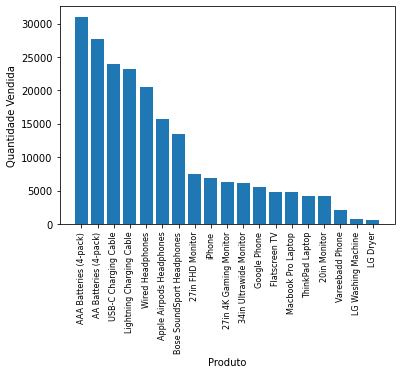

In [ ]:
# Agrupando os produtos e somando as quantidades
produto_agrupamento = df.groupby('Produto').sum().sort_values('Quantidade', ascending=False)

# Fazendo um gráfico de barras para relacionar esses dados
plt.bar(produto_agrupamento.index, produto_agrupamento['Quantidade'])
plt.xticks(produto_agrupamento.index, rotation='vertical', size=8)
plt.ylabel('Quantidade Vendida')
plt.xlabel('Produto')
plt.show()


Vemos que **o produto mais vendido foi o pacote de pilhas AAA**, seguido pelo pacote de pilhas AA e depois por cabos e fones de ouvido. Pode se imaginar que tais itens foram os mais vendidos por representarem produtos de preço unitário baixo, quando comparado aos outros. Em seguida plotaremos no mesmo gráfico os dados de preço dos produtos, para visualizarmos se há relação, e também calcularemos o coeficiente de correlação de Pearson, para vermos se há correlação estatisticamente relevante entre essas duas variáveis.

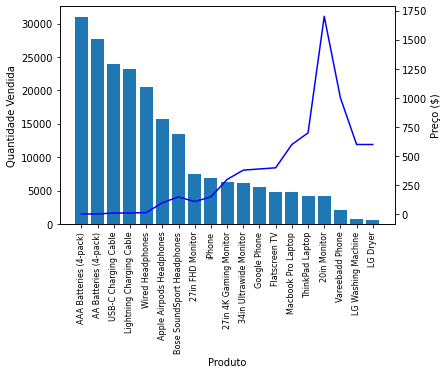

In [ ]:
# Pegando apenas o preço unitário dos produtos
preços = df.groupby('Produto').mean().sort_values('Quantidade', ascending=False)['Preço Unitário']

# Esse gráfico terá dois eixos (ax1 e ax2)
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

# Eixo 1 será o mesmo gráfico de barras anterior
ax1.bar(produto_agrupamento.index, produto_agrupamento['Quantidade'])
ax2.plot(produto_agrupamento.index, preços, color='b')

ax1.set_xlabel('Produto')
ax1.set_ylabel('Quantidade Vendida')
ax2.set_ylabel('Preço ($)')
ax1.set_xticklabels(product_group.index, rotation='vertical', size=8)

plt.show()

Podemos ver que parece realmente haver uma correlação entre o preço unitário e a quantidade vendida, que aumenta conforme o preço diminui, com algumas exceções (como por exemplo os três produtos menos vendidos)

In [ ]:
# Criação de outro DataFrame para correlacionar preço com quantidade vendida
df_correlação = pd.DataFrame()

df_correlação['Produto'] = produto_agrupamento.index
df_correlação['Preço'] = preços.values
df_correlação['Quantidade'] = produto_agrupamento['Quantidade'].values

df_correlação.head(2)

,Produto,Preço,Quantidade
0,AAA Batteries (4-pack),2.99,31017
1,AA Batteries (4-pack),3.84,27635


Podemos usar o método ```.corr()``` para calcular a correlação estatísica entre esses duas variáveis (preço e quantidade vendida). Lembrando que:

* 0.9 para mais ou para menos indica uma correlação muito forte.
* 0.7 a 0.9 positivo ou negativo indica uma correlação forte.
* 0.5 a 0.7 positivo ou negativo indica uma correlação moderada.
* 0.3 a 0.5 positivo ou negativo indica uma correlação fraca.
* 0 a 0.3 positivo ou negativo indica uma correlação desprezível.



In [ ]:
df_correlação['Quantidade'].corr(df_correlação['Preço'])

-0.65571842834477

Visto que a correlação resultante foi de -0.656, nos indica que existe uma correlação moderada entre o preço do produto e a quantidade vendida

### Qual produto que mais dá receita?
Além de saber o produto mais vendido, faz sentido entendermos o produto que mais gera receita para a empresa

Para isso, iniciaremos da mesma forma que a pergunta anterior, mas usaremos a coluna 'Revenue' para ver o total de receita gerado pelos produtos

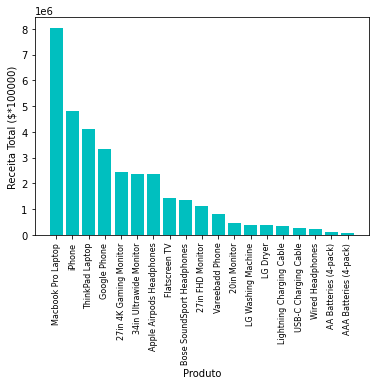

In [ ]:
produto_agrupamento2 = df.groupby('Produto').sum().sort_values('Receita', ascending=False)

plt.bar(produto_agrupamento2.index, produto_agrupamento2['Receita'], color='c')
plt.xticks(produto_agrupamento2.index, rotation='vertical', size=8)
plt.ylabel('Receita Total ($*100000)')
plt.xlabel('Produto')
plt.show()

Com essa visualização fica claro que **o produto que mais gera receita é o Macbook Pro Laptop**, liderando esse ranking. Outro insight interessante de se perceber é que os 5 produtos mais vendidos em quantidade são os 5 que dão menos receita (devido ao preço unitário baixo, conforme visto anteriormente)

### Qual cidade que mais dá receita?

Com a coluna de cidade já feita, é fácil de respondermos essa pergunta.

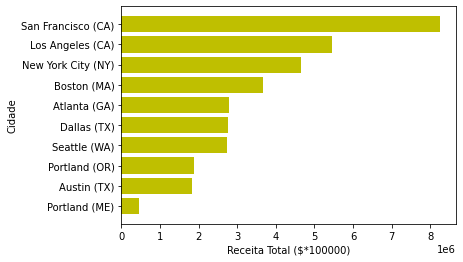

In [ ]:
cidade_agrupamento = df.groupby('Cidade').sum().sort_values('Receita')

plt.barh(cidade_agrupamento.index, cidade_agrupamento['Receita'], color='y')
plt.ylabel('Cidade')
plt.xlabel('Receita Total ($*100000)')
plt.show()

Percebe-se que **a cidade de São Francisco é a maior geradora de receita pra empresa**, seguida por Los Angeles, outra cidade do mesmo estado. 


### Como as vendas se distribuem ao longo do dia?
Podemos verificar o comportamento das vendas de acordo com seu horário

Para isso, usaremos um gráfico de linhas relacionando o horário do dia com a quantidade de produtos vendidos

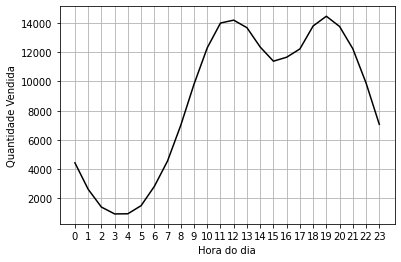

In [ ]:
hora_agrupamento = df.groupby('Hora').sum()

plt.plot(hora_agrupamento.index, hora_agrupamento['Quantidade'], color='black')
plt.xticks(hora_agrupamento.index)
plt.ylabel('Quantidade Vendida')
plt.xlabel('Hora do dia')
plt.grid()
plt.show()

Podemos ver que das 9h às 21h30 ocorrem mais vendas, acima de 11000 produtos por hora. Existem dois picos ao longo do dia, das 11h às 13h e das 18h às 20h. Provavelmente esses horários têm mais vendas por não serem horários típicos em que pessoas trabalham. 

11h - 13h é um intervalo em que ocorrem pausas para almoço

18h - 20h é um horário típico de saída de expediente

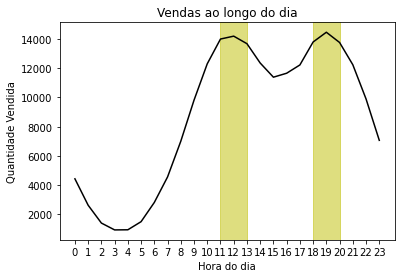

In [ ]:
# Outro gráfico, enfatizando os horários de pico
fig, ax1 = plt.subplots()
plt.plot(hour_group.index, hora_agrupamento['Quantidade'], color='black')
plt.xticks(hora_agrupamento.index)
plt.title('Vendas ao longo do dia')
plt.ylabel('Quantidade Vendida')
plt.xlabel('Hora do dia')
ax1.axvspan(11, 13, alpha=0.5, color='y')
ax1.axvspan(18, 20, alpha=0.5, color='y')
plt.show()


### Quais produtos são os mais vendidos em conjunto?
Existem produtos que são vendidos em duplas? Quais são eles e quais são as combinações mais frequentes?

Conseguimos encontrar produtos vendidos juntos quando existe mais de um produto na mesma ID da ordem.

In [83]:
# Fazendo um novo DataFrame, para excluir IDs que tiveram apenas um produto vendido

df_conjuntos = df[df['ID da ordem'].duplicated(keep=False)]
df_conjuntos = df_conjuntos.sort_values(['ID da ordem','Produto']) # Ordenar pelo nome do produto, 
                                                        # pra todas as combinações terem a mesma ordem (alfabética)

df_conjuntos.head(6)

,ID da ordem,Produto,Quantidade,Preço Unitário,Data,Endereço,Mês,Hora,Cidade,Receita
67588,141275,USB-C Charging Cable,1,11.95,2019-01-07 16:06:00,"610 Walnut St, Austin, TX 73301",1,16,Austin (TX),11.95
67589,141275,Wired Headphones,1,11.99,2019-01-07 16:06:00,"610 Walnut St, Austin, TX 73301",1,16,Austin (TX),11.99
67605,141290,AA Batteries (4-pack),3,3.84,2019-01-02 08:25:00,"4 1st St, Los Angeles, CA 90001",1,8,Los Angeles (CA),11.52
67604,141290,Apple Airpods Headphones,1,150.00,2019-01-02 08:25:00,"4 1st St, Los Angeles, CA 90001",1,8,Los Angeles (CA),150.00
67680,141365,Vareebadd Phone,1,400.00,2019-01-10 11:19:00,"20 Dogwood St, New York City, NY 10001",1,11,New York City (NY),400.00
67681,141365,Wired Headphones,1,11.99,2019-01-10 11:19:00,"20 Dogwood St, New York City, NY 10001",1,11,New York City (NY),11.99


Para realizarmos a análise dos conjuntos de produtos vendidos, faremos uma nova coluna **Conjunto**, que juntará os produtos

In [86]:
# A seguinte fórmula está criando a nova coluna, unindo os produtos da mesma ordem
df_conjuntos['Conjunto'] = df_conjuntos.groupby('ID da ordem')['Produto'].transform(lambda x: ','.join(x))

df_conjuntos.head(6)

,ID da ordem,Produto,Quantidade,Preço Unitário,Data,Endereço,Mês,Hora,Cidade,Receita,Conjunto
67588,141275,USB-C Charging Cable,1,11.95,2019-01-07 16:06:00,"610 Walnut St, Austin, TX 73301",1,16,Austin (TX),11.95,"USB-C Charging Cable,Wired Headphones"
67589,141275,Wired Headphones,1,11.99,2019-01-07 16:06:00,"610 Walnut St, Austin, TX 73301",1,16,Austin (TX),11.99,"USB-C Charging Cable,Wired Headphones"
67605,141290,AA Batteries (4-pack),3,3.84,2019-01-02 08:25:00,"4 1st St, Los Angeles, CA 90001",1,8,Los Angeles (CA),11.52,"AA Batteries (4-pack),Apple Airpods Headphones"
67604,141290,Apple Airpods Headphones,1,150.00,2019-01-02 08:25:00,"4 1st St, Los Angeles, CA 90001",1,8,Los Angeles (CA),150.00,"AA Batteries (4-pack),Apple Airpods Headphones"
67680,141365,Vareebadd Phone,1,400.00,2019-01-10 11:19:00,"20 Dogwood St, New York City, NY 10001",1,11,New York City (NY),400.00,"Vareebadd Phone,Wired Headphones"
67681,141365,Wired Headphones,1,11.99,2019-01-10 11:19:00,"20 Dogwood St, New York City, NY 10001",1,11,New York City (NY),11.99,"Vareebadd Phone,Wired Headphones"


Agora modificaremos essa tabela, para apenas conter o que necessitamos para essa análise: apenas o ID e seus produtos vendidos

In [87]:
# Essa fórmula pega apenas as colunas desejadas e remove os valores duplicados 
#    (para não repetir as IDs)
df_conjuntos = df_conjuntos[['ID da ordem', 'Conjunto']].drop_duplicates()

df_conjuntos.head()

,ID da ordem,Conjunto
67588,141275,"USB-C Charging Cable,Wired Headphones"
67605,141290,"AA Batteries (4-pack),Apple Airpods Headphones"
67680,141365,"Vareebadd Phone,Wired Headphones"
67700,141384,"Google Phone,USB-C Charging Cable"
67768,141450,"Bose SoundSport Headphones,Google Phone"


Agora com todos os conjuntos listados, podemos montar um gráfico de barras para visualizarmos quais os mais vendidos

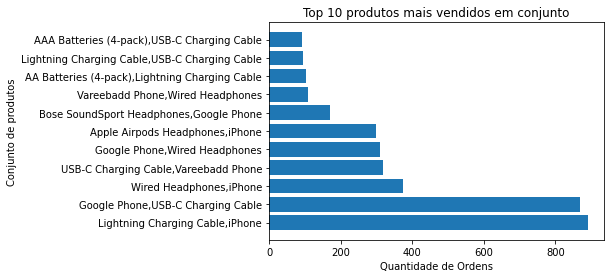

In [102]:
contagem_de_conjuntos = df_conjuntos['Conjunto'].value_counts()[:11]

plt.barh(contagem_de_conjuntos.index,contagem_de_conjuntos)
plt.title('Top 10 produtos mais vendidos em conjunto')
plt.xlabel('Quantidade de Ordens')
plt.ylabel('Conjunto de produtos')
plt.show()

Podemos ver que os conjuntos mais vendidos são de **Telefone + Cabo para carregar**. Isso faz muito sentido de acontecer, pois um telefone novo não tem muita serventia sem um cabo para carregá-lo.

A maioria dos conjuntos mais vendidos se dão com essa configuração Telefone + Acessório (como um cabo ou fone de ouvido)